In [ ]:
import mygdal
import mydas
import numpy
import mynumpy
from datetime import datetime

from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

from matplotlib import pyplot as plt
from matplotlib import cm


plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 10
plt.rcParams["text.usetex"] = False
plt.rcParams["font.weight"] = "normal"

mygdal_doy = mygdal.Mygdal('/dados/d2/rolf/STACK/doy.tif')
mygdal_ndvi = mygdal.Mygdal('/dados/d2/rolf/STACK/ndvi.tif')
mygdal_evi = mygdal.Mygdal('/dados/d2/rolf/STACK/evi.tif')

In [2]:
def pick_colors(cmap_str, categories, include_extrems=True):
    result = []
    cmap = cm.get_cmap(cmap_str)
    unique_categories, index_categories = numpy.unique(categories, return_inverse=True)
    if len(unique_categories) == 1:
        unique_categories = range(len(categories))
        index_categories = range(len(categories))
    n = len(unique_categories)
    increment = 0 if include_extrems else 1
    for index in index_categories:
        result.append(cmap((index + increment) / (n + increment)))
    return result

In [3]:
# This is a function that implements a Whittaker smoother in Python. 
# Reference: Paul H. C. Eilers. "A Perfect Smoother". Analytical Chemistry, 2003, 75 (14), pp 3631–3636.
# Source: https://gist.github.com/zmeri/3c43d3b98a00c02f81c2ab1aaacc3a49

import scipy
import scipy.sparse.linalg


def whittaker_smooth(y, lmda=1.0):
    m = len(y)
    E = scipy.sparse.identity(m)
    d1 = -1 * numpy.ones((m), dtype='d')
    d2 = 3 * numpy.ones((m), dtype='d')
    d3 = -3 * numpy.ones((m), dtype='d')
    d4 = numpy.ones((m), dtype='d')
    D = scipy.sparse.diags([d1, d2, d3, d4], [0, 1, 2, 3], shape=(m - 3, m), format="csr")
    z = scipy.sparse.linalg.cg(E + lmda * (D.transpose()).dot(D), y)
    return z[0]

In [4]:
timeline = mydas.from_recarray(numpy.recfromcsv('../data/timeline_new2.csv', 
                                               dtype=[('source', 'U3'), ('date', 'datetime64[D]')]))
timeline['base_date'] = numpy.array(timeline['date'], dtype='datetime64[Y]')

In [5]:
samples = mydas.from_recarray(numpy.recfromcsv('../data/samples_new2.csv', 
                                              dtype=[('longitude', 'f8'), 
                                                     ('latitude', 'f8'), 
                                                     ('from', 'datetime64[D]'), 
                                                     ('to', 'datetime64[D]'), 
                                                     ('label', 'U14')]))
samples['geoloc'] = numpy.array([samples['longitude'], samples['latitude']]).T
samples['pixel'] = mygdal_doy.geolocs_to_pixels(samples['geoloc'])
samples.orderby(keys='latitude', reverse=True)

mydas.head(samples)

{
longitude: [ 611007.86624535604 614950.01863124198 615181.91125486302 610959.94890303304 611191.83905921096 ...] 
latitude: [ -1325491.78547118 -1325506.6182283999 -1325507.5068682199 -1325722.0157840599 -1325722.8737497199 ...] 
from: [ '2010-09-01' '2011-09-01' '2011-09-01' '2010-09-01' '2010-09-01' ...] 
to: [ '2011-09-01' '2012-09-01' '2012-09-01' '2011-09-01' '2011-09-01' ...] 
label: [ 'Soybean-maize' 'Cotton-fallow' 'Cotton-fallow' 'Soybean-maize' 'Soybean-maize' ...] 
geoloc: [ [ 611007.86624535604 -1325491.78547118 ] [ 614950.01863124198 -1325506.6182283999 ] [ 615181.91125486302 -1325507.5068682199 ] [ 610959.94890303304 -1325722.0157840599 ] [ 611191.83905921096 -1325722.8737497199 ] ...] 
pixel: [ [ 74 20 ] [ 205 21 ] [ 213 21 ] [ 72 28 ] [ 80 28 ] ...] 
}


In [6]:
def pixel_timeseries(pixel, mygdal_doy, base_dates, mygdal_values, factor_value, min_value, max_value):
    result = mydas.mydas()
    doys = mygdal_doy.read_pixel(pixel, default_value=0.0, 
                                 factor_value=100000, min_value=0, max_value=366, dtype='timedelta64[D]')
    dates = base_dates + doys
    values = mygdal_values.read_pixel(pixel, factor_value=factor_value, 
                                      min_value=min_value, max_value=max_value, dtype='f8')
    good_values = ~numpy.isnan(values)
    argsort = numpy.argsort(dates[good_values])
    result['dates'] = dates[good_values][argsort]
    result['source'] = timeline['source'][good_values][argsort]
    result['values'] = values[good_values][argsort]
    result = result.aggregate(values=['source', 'values'], 
                              funcs=['_'.join, numpy.mean], 
                              groupby='dates')
    result['dates_dt'] = result['dates'].astype(datetime)
    return result


def prepare_pixel_timeseries(pixel_ts, sample_from, sample_to, slices=None, smooth_func=None):
    result = pixel_ts.where((pixel_ts['dates'] >= sample_from) * (pixel_ts['dates'] <= sample_to))
    if slices is not None:
        result = result.regularize('dates', slices=slices, interp_keys=['values'])
        result['dates_dt'] = result['dates'].astype(datetime)
    if smooth_func is not None:
        result['values'] = smooth_func(result['values'], 1.0)
    result['doys'] = mynumpy.datetime64_doy(result['dates'], sample_from)
    return result
        

def sample_timeseries(sample_id, samples, mygdal_doy, base_dates, 
                      mygdal_values, factor_value, min_value, max_value,
                      slices=None, smooth_func=None, return_pixel_ts=False):
    """
    :rtype: mydas.mydas
    """
    pixel_ts = pixel_timeseries(pixel=samples['pixel'][sample_id], mygdal_doy=mygdal_doy, 
                                base_dates=base_dates, mygdal_values=mygdal_values,
                                factor_value=factor_value, min_value=min_value, max_value=max_value)
    sample_ts = prepare_pixel_timeseries(pixel_ts, 
                                         sample_from=samples['from'][sample_id], 
                                         sample_to=samples['to'][sample_id],
                                         slices=slices,
                                         smooth_func=smooth_func)
    if return_pixel_ts:
        return sample_ts, pixel_ts
    return sample_ts


def plot_samples(samples, mygdal_doy, base_dates, mygdal_values, factor_value, min_value, max_value,
                 slices=None, smooth_func=None, plot_index='dates_dt', plot_xlabel='', plot_ylabel='',
                 plot_colormap='jet', plot_linewidth=1.0, plot_alpha=1.0):
    if len(samples):
        sample_ts = None
        colors = pick_colors(plot_colormap, samples['label'])
        for i in range(len(samples)):
            sample_ts = sample_timeseries(sample_id=i, samples=samples, mygdal_doy=mygdal_doy,
                                          base_dates=base_dates, mygdal_values=mygdal_values,
                                          factor_value=factor_value, min_value=min_value, max_value=max_value,
                                          slices=slices, smooth_func=smooth_func)
            plt.plot(*sample_ts[plot_index, 'values'], 
                     color=colors[i], linewidth=plot_linewidth, alpha=plot_alpha)
        if sample_ts is not None:
            plt.xlim([numpy.min(sample_ts[plot_index]), numpy.max(sample_ts[plot_index])])
            plt.ylim([min(0, numpy.min(sample_ts['values'])), max_value])
            plt.xlabel(plot_xlabel)
            plt.ylabel(plot_ylabel)
            plt.show()

In [7]:
# Adapted from: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html


def linear(x):
    return x


def logistic(x, alpha, beta):
    return 1.0 / (1.0 + numpy.exp(-alpha * (x - beta)))


def cross_distances(a, b, func, *func_params):
    s0, s1 = numpy.meshgrid(a, b)
    return func(numpy.abs(s0 - s1), *func_params)


def DTW_prepare(len1, len2):
    return numpy.zeros((len1 + 1, (len2 + 1)))


def DTW(dists, window=None, result=None):
    if result is None:
        result = numpy.zeros((len(dists) + 1, (len(dists) + 1)))
    if window is None or window > len(dists):
        window = len(dists)
    result[:, :] = numpy.inf
    result[0, 0] = 0.0
    for i in range(1, len(result)):
        for j in range(max(1, i - window), min(len(result[i]), i + window + 1)):
            result[i, j] = numpy.nanmin(result[i-1:i+1, j-1:j+1]) + dists[i-1, j-1]
    return result


def DTW_dist_reg_tss(tss, window, date_key, value_key, dist_date_func, func_date_params, 
                     dist_value_func, func_value_params):
    result = []
    dtw_dists = DTW_prepare(len(tss[0][date_key]), len(tss[0][date_key]))
    index_dist = cross_distances(tss[0][date_key], tss[0][date_key], dist_date_func, *func_date_params) 
    for i in range(len(tss) - 1):
        for j in range(i + 1, len(tss)):
            values_dist = cross_distances(tss[i][value_key], tss[j][value_key], dist_value_func, *func_value_params)
            DTW(index_dist + values_dist, window=window, result=dtw_dists)
            result.append(dtw_dists[-1, -1])
    return result


def plot_dtw_dist(ts1, ts2, window, date_key, value_key, 
                  dist_date_func, func_date_params, dist_value_func, func_value_params):
    dates_dist = cross_distances(ts1[date_key], ts2[date_key], 
                                 dist_date_func, *func_date_params)
    values_dist = cross_distances(ts1[value_key], ts2[value_key], 
                                  dist_value_func, *func_value_params)
    dtw_dists = DTW_prepare(len(ts1), len(ts2))
    dtw_dists = DTW(dates_dist + values_dist, result=dtw_dists)

    fig = plt.figure(figsize=(10,4))
    s = fig.add_subplot(1, 3, 1)
    im = s.imshow(values_dist, cmap='YlOrRd', interpolation='nearest')
    fig.colorbar(im)
    s = fig.add_subplot(1, 3, 2)
    im = s.imshow(dates_dist + values_dist, cmap='YlOrRd', interpolation='nearest')
    fig.colorbar(im)
    s = fig.add_subplot(1, 3, 3)
    im = s.imshow(dtw_dists[1:,1:], cmap='YlOrRd', interpolation='nearest')
    fig.colorbar(im)
    #print(dtw_dists[-1,-1])
    #plt.xlabel('DTW distance')
    #plt.ylabel('DTW distance')
    plt.show()

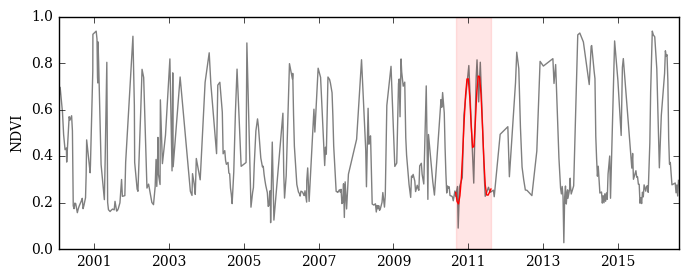

In [8]:
sample_id = 0

pixel_ts = pixel_timeseries(pixel=samples['pixel'][sample_id], mygdal_doy=mygdal_doy, 
                            base_dates=timeline['base_date'], mygdal_values=mygdal_ndvi,
                            factor_value=10, min_value=-1, max_value=1)

sample_ts_reg = prepare_pixel_timeseries(pixel_ts, 
                                         sample_from=samples['from'][sample_id], 
                                         sample_to=samples['to'][sample_id],
                                         slices=26,
                                         smooth_func=whittaker_smooth)

plt.figure(figsize=(8, 3))
plt.plot(*pixel_ts['dates_dt', 'values'], color='black', alpha=0.5)
plt.plot(*sample_ts_reg['dates_dt', 'values'], color='red', alpha=1.0)
plt.fill_between(sample_ts_reg['dates_dt'], 0, 1, color='red', alpha=0.1)
plt.ylabel('NDVI')
plt.show()

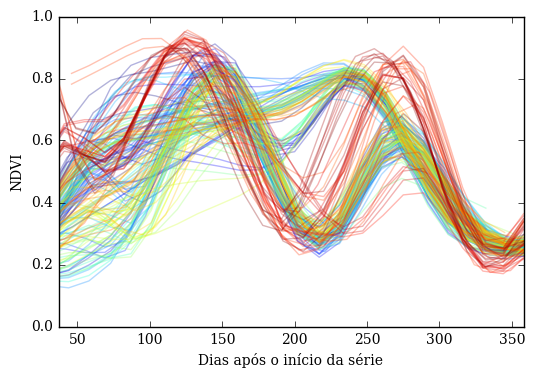

In [9]:
plot_samples(samples.where(samples['label']=='Soybean-millet'), mygdal_doy, timeline['base_date'], 
             mygdal_ndvi, factor_value=10, min_value=-1, max_value=1,
             slices=26, smooth_func=whittaker_smooth, plot_index='doys', 
             plot_xlabel='Dias após o início da série', plot_ylabel='NDVI', 
             plot_colormap='jet', plot_linewidth=1.0, plot_alpha=0.3)

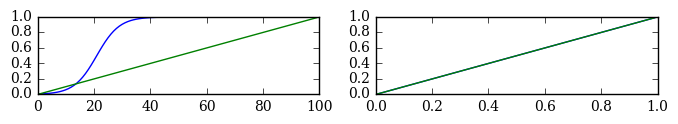

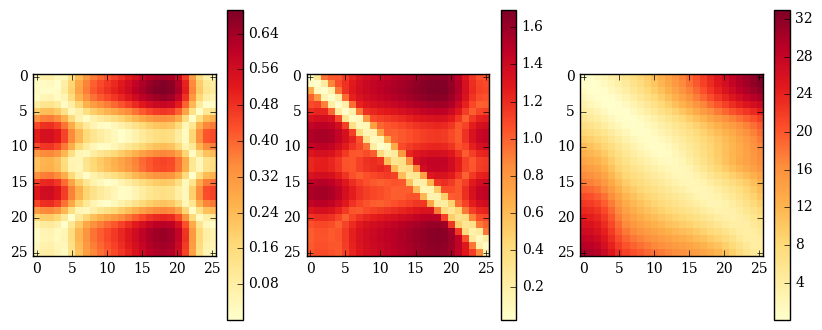

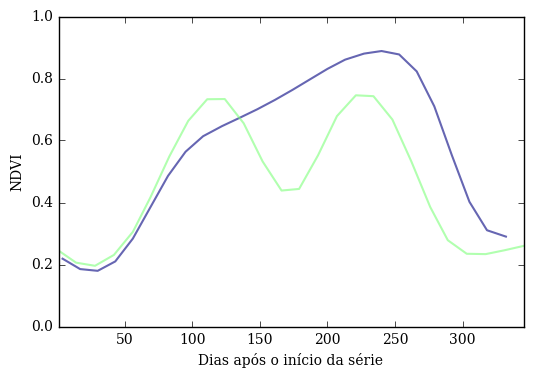

In [10]:
date_func = logistic
date_func_params = (0.25, 21) # doy: (0.25, 21)
value_func = linear
value_func_params = ()        # ndvi: (40, 0.15)
labels = {}
for i, value in enumerate(numpy.unique(samples['label'])):
    labels[value] = i
# distance of time warp
x = numpy.arange(0, 100, 1)
fig = plt.figure(figsize=(8,1))
s = fig.add_subplot(1, 2, 1)
s.plot(x, [date_func(i, *date_func_params) for i in x])
s.plot(x, x / 100)

# distance of value warp
x = numpy.arange(0, 1, 0.01)
s = fig.add_subplot(1, 2, 2)
s.plot(x, [value_func(i, *value_func_params) for i in x])
s.plot(x, x)

plt.show()

sample_id1=2
sample_id2=0

ts1 = sample_timeseries(sample_id=sample_id1, samples=samples, mygdal_doy=mygdal_doy, 
                        base_dates=timeline['base_date'], 
                        mygdal_values=mygdal_ndvi, factor_value=10, min_value=-1, max_value=1,
                        slices=26, smooth_func=whittaker_smooth)

ts2 = sample_timeseries(sample_id=sample_id2, samples=samples, mygdal_doy=mygdal_doy, 
                        base_dates=timeline['base_date'], 
                        mygdal_values=mygdal_ndvi, factor_value=10, min_value=-1, max_value=1,
                        slices=26, smooth_func=whittaker_smooth)

plot_dtw_dist(ts1=ts1, ts2=ts2, window=2, date_key='doys', value_key='values', 
              dist_date_func=logistic, func_date_params=date_func_params, 
              dist_value_func=linear, func_value_params=value_func_params)

plot_samples(samples.where([sample_id1, sample_id2]), mygdal_doy, timeline['base_date'], 
             mygdal_ndvi, factor_value=10, min_value=-1, max_value=1,
             slices=26, smooth_func=whittaker_smooth, plot_index='doys', 
             plot_xlabel='Dias após o início da série', plot_ylabel='NDVI', 
             plot_colormap='jet', plot_linewidth=1.5, plot_alpha=0.6)

In [11]:
######################################################################################
######################################################################################
######################################################################################

tss_label = 'all'
tss_samples = samples

dtw_window = 2

date_func = logistic
date_func_params = (0.25, 21) # doy: (0.25, 21)
value_func = linear
value_func_params = () # ndvi: (40, 0.15)

In [12]:
tss = [sample_timeseries(sample_id=i, samples=tss_samples, mygdal_doy=mygdal_doy,
                         base_dates=timeline['base_date'], mygdal_values=mygdal_ndvi,
                         factor_value=10, min_value=-1, max_value=1,
                         slices=26, smooth_func=whittaker_smooth) for i in range(len(tss_samples))]

In [13]:
#dtw_dist_triangle = DTW_dist_reg_tss(tss=tss, window=dtw_window, date_key='doys', value_key='values', 
#                                     dist_date_func=date_func, func_date_params=date_func_params, 
#                                     dist_value_func=value_func, func_value_params=value_func_params)

In [14]:
#numpy.savetxt('../data/dtw_distances/twdtw_w{:d}_{}.txt'.format(dtw_window, tss_label), 
#              dtw_dist_triangle, delimiter=',', 
#              header='triangle_matrix',
#              comments='# date: {}{}'.format(str(date_func.__name__), str(date_func_params)) + \
#                  'values: {}{}'.format(str(value_func.__name__), str(value_func_params)) + '\n')

In [15]:
dtw_dist_triangle = numpy.loadtxt('../data/dtw_distances/twdtw_w{:d}_{}.txt'.format(dtw_window, tss_label), 
                                   comments='#', delimiter=',', skiprows=2)

In [16]:
# Source: 

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [17]:
Z = linkage(dtw_dist_triangle, 'complete')

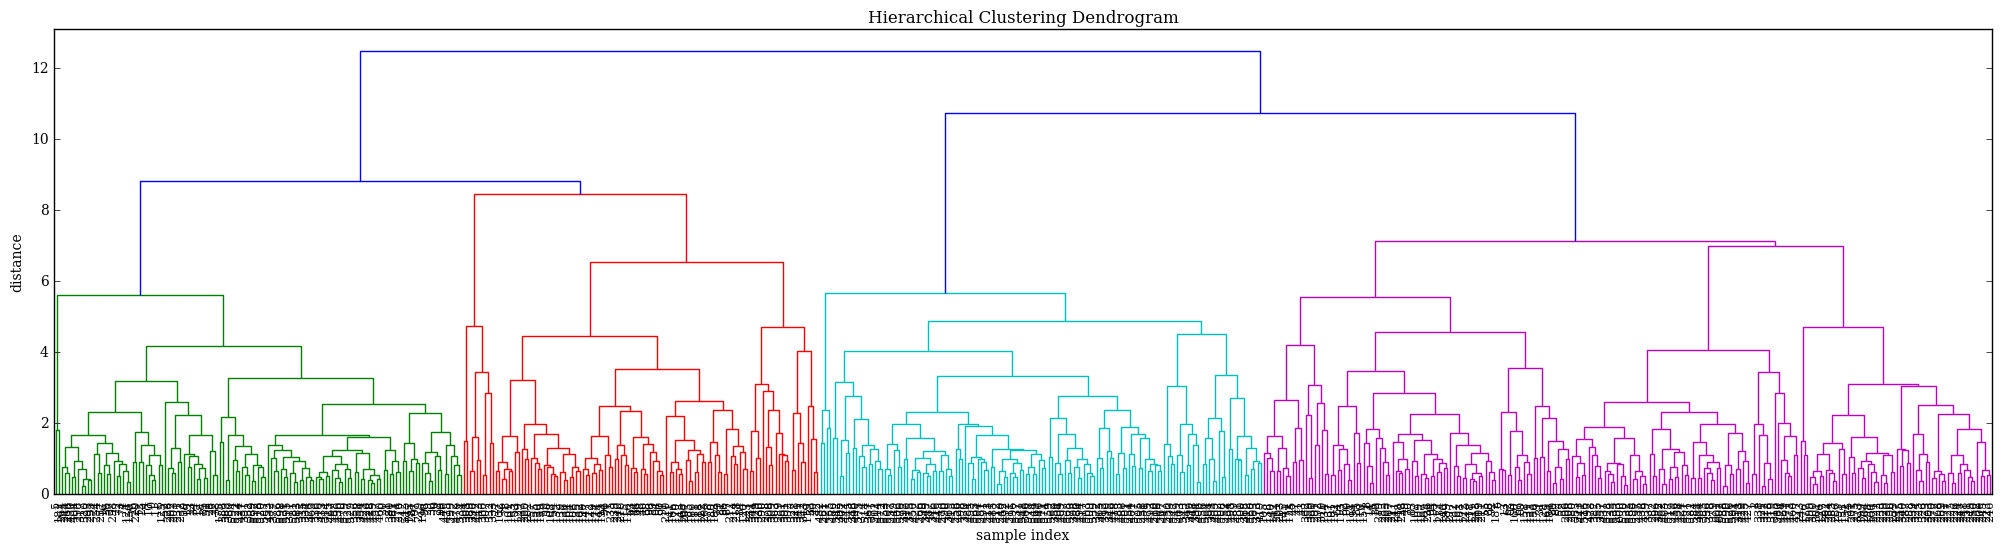

[  3.2622679    3.33353058   3.36381637   3.43821782   3.44029321
   3.4824704    3.5169712    3.55548907   4.03886798   4.03973319
   4.07541575   4.17274826   4.20486494   4.45543033   4.52264154
   4.57729556   4.70168566   4.72255656   4.74633693   4.87647157
   5.56690476   5.61214583   5.6770438    6.53106952   7.00174962
   7.14371549   8.46787244   8.82646938  10.72837454  12.48066702]


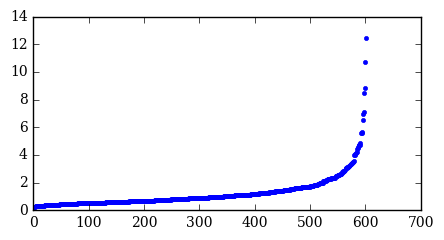

In [18]:
from scipy.cluster.hierarchy import cophenet


#cophenet_matrix = distance.squareform(cophenet(Z))
# plt.figure(figsize=(2, 2))
# plt.imshow(cophenet_matrix, cmap='YlOrRd', interpolation='nearest')

plt.figure(figsize=(25, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# last distances
print(Z[-30:,2])
plt.figure(figsize=(5, 2.5))
plt.plot(Z[:,2], '.')
plt.show()

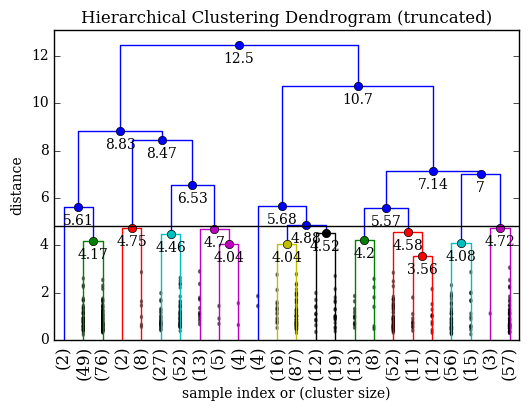

In [19]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=24,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1.0,
    max_d=4.8
)
plt.show()

In [20]:
max_d = 4.8
clusters = fcluster(Z, max_d, criterion='distance')

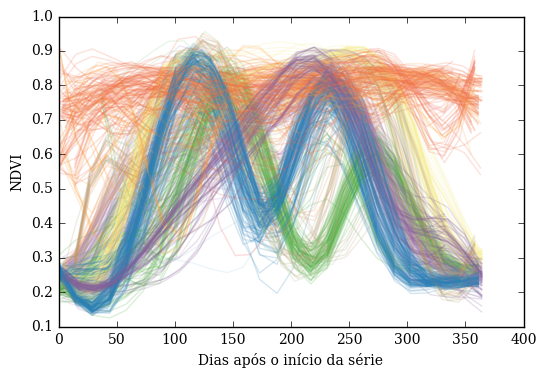

In [21]:
colors = pick_colors('Paired', clusters, include_extrems=True)

for i in range(len(tss)):
    plt.plot(*tss[i]['doys', 'values'], color=colors[i], linewidth=1, alpha=0.2)
plt.xlabel('Dias após o início da série')
plt.ylabel('NDVI')
plt.show()

In [22]:
ts_compact = mydas.compact(tss, 'doys', 'values')

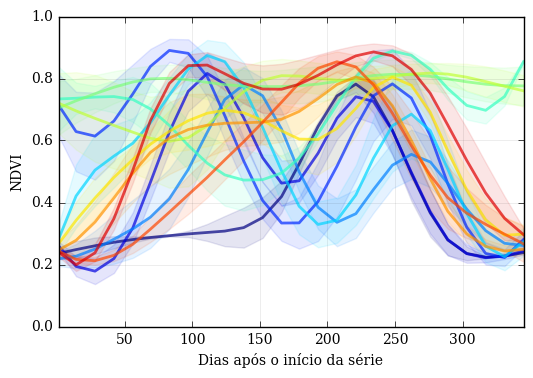

In [23]:
colors = pick_colors('jet', numpy.unique(clusters), True)
plt.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
x = ts_compact['doys']

for i in range(max(clusters)):
    y = whittaker_smooth(ts_compact['values'][:, clusters==(i + 1)].mean(axis=1), 1.0)
    error = whittaker_smooth(ts_compact['values'][:, clusters==(i + 1)].std(axis=1), 1.0)
    plt.fill_between(x, y - error, y + error, color=colors[i], alpha=0.1)
    plt.plot(x, y, color=colors[i], linewidth=2, alpha=0.7)

plt.xlim([min(ts_compact['doys']), max(ts_compact['doys'])]) 
plt.ylim([0, 1]) 
plt.xlabel('Dias após o início da série')
plt.ylabel('NDVI')
plt.show()

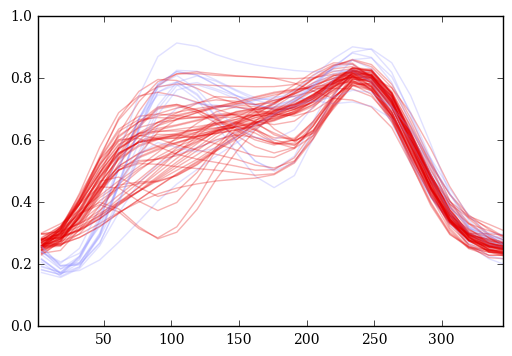

In [24]:
colors = pick_colors('seismic', samples['label'])
for i in range(len(tss)):
    if (clusters[i] == 10):
        plt.plot(*tss[i]['doys', 'values'], color=colors[i], linewidth=1, alpha=0.3)
plt.xlim([min(ts_compact['doys']), max(ts_compact['doys'])])
plt.ylim([0, 1])
plt.show()

[[   0.    0.    0.    1.    1.]
 [   0.    0.    0.  125.    0.]
 [   0.    0.    0.    0.   10.]
 [   0.    0.    0.    8.   71.]
 [   0.    0.    0.    0.   22.]
 [   0.    4.    0.    0.    0.]
 [   0.  103.    0.    0.    0.]
 [   0.   31.    0.    0.    0.]
 [   0.    0.    0.    0.   21.]
 [   0.    0.   16.    0.   59.]
 [  68.    0.    3.    0.    0.]
 [   0.    0.   60.    0.    0.]]


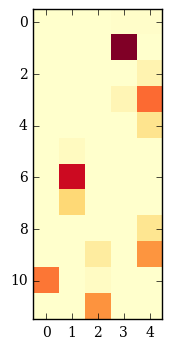

In [25]:
labels = {}
for i, value in enumerate(numpy.unique(samples['label'])):
    labels[value] = i
confusion = numpy.zeros((max(clusters), len(labels)))
for i in range(len(samples['label'])):
    confusion[clusters[i] - 1][labels[samples['label'][i]]] += 1
print(confusion)

plt.imshow(confusion, cmap='YlOrRd', interpolation='nearest')
plt.grid(b=True, which='minor', color='k', linestyle='-', alpha=1)
plt.show()